In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
torch.cuda.empty_cache()

# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# seperating the multiple tif image into single images  
##def separate(path, save_path):
    # Open the TIFF file
##    im = Image.open(path)

    # Iterate over the images in the TIFF file and save each image as a separate file
##    i = 0
##    try:
##        while True:
##            im.seek(i)
##            im.save(f'{save_path}image_{i}.tif')
##            i += 1
##    except EOFError:
##        pass

# Specify the path where the TIFF files are located
##path = "./DATA/"

# Iterate over each subdirectory in the specified path
##for i in os.listdir(path):
    # Call the separate function for each TIFF file in the subdirectory
##    separate(path+i+"/"+os.listdir(path+i)[0], path+i+"/")


In [2]:
class UNET_down(nn.Module):
    def __init__(self):
        super(UNET_down, self).__init__()
        
        init_dim = 32
        
        self.conv1 = nn.Conv2d(1, init_dim, 3, padding=1)
        self.conv1_ = nn.Conv2d(init_dim, init_dim, 3, padding=1)
        
        self.conv2 = nn.Conv2d(init_dim, init_dim*2, 3, padding=1)
        self.conv2_ = nn.Conv2d(init_dim*2, init_dim*2, 3, padding=1)
        
        self.conv3 = nn.Conv2d(init_dim*2, init_dim*4, 3, padding=1)
        self.conv3_ = nn.Conv2d(init_dim*4, init_dim*4, 3, padding=1)
        
        self.conv4 = nn.Conv2d(init_dim*4, init_dim*8, 3, padding=1)
        self.conv4_ = nn.Conv2d(init_dim*8, init_dim*8, 3, padding=1)
        
        self.BN1 = nn.BatchNorm2d(init_dim)
        self.BN2 = nn.BatchNorm2d(init_dim*2)
        self.BN3 = nn.BatchNorm2d(init_dim*4)
        self.BN4 = nn.BatchNorm2d(init_dim*8)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(2, 2)
        
        
    def forward(self, x):
        
        #building unet parts (3 operations for each step)
        x1 = self.conv1(x)
        x1 = self.BN1(x1)
        x1 = self.relu(x1)
        
        x1 = self.conv1_(x1)
        x1 = self.BN1(x1)
        x1 = self.relu(x1) #256x256x64
        x2 = self.maxpool(x1) #128x128x64
        
        x2 = self.conv2(x2)
        x2 = self.BN2(x2)
        x2 = self.relu(x2)
        
        x2 = self.conv2_(x2)
        x2 = self.BN2(x2)
        x2 = self.relu(x2) #128x128x128
        x3 = self.maxpool(x2) #64x64x128
        
        x3 = self.conv3(x3)
        x3 = self.BN3(x3)
        x3 = self.relu(x3)
        
        x3 = self.conv3_(x3)
        x3 = self.BN3(x3)
        x3 = self.relu(x3) #64x64x256
        x4 = self.maxpool(x3) #32x32x256
        
        x4 = self.conv4(x4)
        x4 = self.BN4(x4)
        x4 = self.relu(x4)
        
        x4 = self.conv4_(x4)
        x4 = self.BN4(x4)
        x4 = self.relu(x4) #32x32x512
        x5 = self.maxpool(x4) #16x16x512
        
        x5 = self.conv4_(x5)
        x5 = self.BN4(x5)
        x5 = self.relu(x5)
        
        x5 = self.conv4_(x5)
        x5 = self.BN4(x5)
        x5 = self.relu(x5) #16x16x512
        
        return x1, x2, x3, x4, x5

In [3]:
class UNET_up(nn.Module):
    def __init__(self):
        super(UNET_up, self).__init__()
        
        init_dim = 512

        self.relu = nn.ReLU()
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True) # upsampling
        self.conv5 = nn.Conv2d(init_dim, init_dim//2, 3, padding=1)
        self.conv5_ = nn.Conv2d(init_dim//2, init_dim//4, 3, padding=1)

        self.BN5 = nn.BatchNorm2d(init_dim//2)
        self.BN5_ = nn.BatchNorm2d(init_dim//4)

        self.conv4 = nn.Conv2d(init_dim//2, init_dim//4, 3, padding=1)
        self.conv4_ = nn.Conv2d(init_dim//4, init_dim//8, 3, padding=1)

        self.BN4 = nn.BatchNorm2d(init_dim//4)
        self.BN4_ = nn.BatchNorm2d(init_dim//8)

        self.conv3 = nn.Conv2d(init_dim//4, init_dim//8, 3, padding=1)
        self.conv3_ = nn.Conv2d(init_dim//8, init_dim//16, 3, padding=1)

        self.BN3 = nn.BatchNorm2d(init_dim//8)
        self.BN3_ = nn.BatchNorm2d(init_dim//16)

        self.conv2 = nn.Conv2d(init_dim//8, init_dim//16, 3, padding=1)
        self.conv2_ = nn.Conv2d(init_dim//16, init_dim//16, 3, padding=1)

        self.BN2 = nn.BatchNorm2d(init_dim//16)
        self.BN2_ = nn.BatchNorm2d(init_dim//16)

        self.convf = nn.Conv2d(init_dim//16,1,1,padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2, x3, x4, x5):
        x5 = self.up(x5)
        x = torch.cat([x4, x5], dim=1)

        x = self.conv5(x)
        x = self.BN5(x)
        x = self.relu(x)

        x = self.conv5_(x)
        x = self.BN5_(x)
        x = self.relu(x)

        x = self.up(x)
        x = torch.cat([x3, x], dim=1)

        x = self.conv4(x)
        x = self.BN4(x)
        x = self.relu(x)

        x = self.conv4_(x)
        x = self.BN4_(x)
        x = self.relu(x)

        x = self.up(x)
        x = torch.cat([x2, x], dim=1)

        x = self.conv3(x)
        x = self.BN3(x)
        x = self.relu(x)

        x = self.conv3_(x)
        x = self.BN3_(x)
        x = self.relu(x)

        x = self.up(x)
        x = torch.cat([x1, x], dim=1)

        x = self.conv2(x)
        x = self.BN2(x)
        x = self.relu(x)

        x = self.conv2_(x)
        x = self.BN2_(x)
        x = self.relu(x)

        x = self.convf(x)
        x = self.sigmoid(x)
        
        return x

In [11]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()

        # Initialize the UNET_down and UNET_up components
        self.convdown = UNET_down()
        self.convup = UNET_up()

    def forward(self, x):
        # Forward pass of the UNet model
        x1, x2, x3, x4, x5 = self.convdown(x)
        x = self.convup(x1, x2, x3, x4, x5)
        return x

# Create an instance of the UNET model
model = UNET()
model.to(device)

UNET(
  (convdown): UNET_down(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (BN1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (BN3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (BN4): BatchNorm2d(256, eps=1e-05, momentum=0.1, 

In [5]:
class datagen(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        # Initialize the required parameters
        self.img_dir = img_dir  # Directory containing the input images
        self.mask_dir = mask_dir  # Directory containing the corresponding masks
        self.transform = transform  # Transformation to be applied to the images and masks
        self.img_filenames = os.listdir(self.img_dir)  # List of image filenames in the directory

    def __len__(self):
        # Return the length of the dataset (number of images)
        return len(self.img_filenames)

    def __getitem__(self, idx):
        # Accessing the data at the given index

        # Get the paths of the image and mask for the current index
        img_path = os.path.join(self.img_dir, self.img_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.img_filenames[idx])

        # Read the image and mask using PIL.Image and convert them to grayscale
        image = Image.open(img_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # Apply the specified transformation to the image and mask
        image, mask = self.transform(image), self.transform(mask)

        # Return the transformed image and mask as the dataset sample
        return image, mask


In [7]:
# Define the transformation pipeline for the data
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize the image and mask to a fixed size of 256x256
    transforms.ToTensor(),  # Convert the image and mask to tensors
])

# Specify the path to the data directory
path = "./DATA"

# Get the subdirectories in the data directory
dirs = [os.path.join(path, i) for i in os.listdir("./DATA")]
dirs

['./DATA/train_x', './DATA/test_x', './DATA/test_y', './DATA/train_y']

In [8]:
# Assign the subdirectories to corresponding variables
trainx_dir, testx_dir, testy_dir, trainy_dir = dirs

# Create the training and testing dataset
train_dataset = datagen(trainx_dir, trainy_dir, transform)
test_dataset = datagen(testx_dir, testy_dir, transform)

# Create the training and testing data loader
train_loader = DataLoader(train_dataset, batch_size=15, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=15, shuffle=False)

In [9]:
class DiceLoss(torch.nn.Module):
    def __init__(self, eps=1e-7):
        super(DiceLoss, self).__init__()
        self.eps = eps

    def forward(self, output, target):
        # output and target are assumed to be (N, C, H, W), where N is batch size, C is num of classes
        # convert to (N, H, W, C)
        output = output.permute(0, 2, 3, 1)
        target = target.permute(0, 2, 3, 1)

        # Flatten the tensor
        output = output.contiguous().view(-1)
        target = target.contiguous().view(-1)

        intersection = (output * target).sum()  # Compute the intersection between output and target
        dice_coef = (2. * intersection + self.eps) / (output.sum() + target.sum() + self.eps)

        return 1. - dice_coef

In [12]:
#training loop
num_epochs = 20
total_step = len(train_loader)
lr = 5e-3

loss_fn = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(1, num_epochs+1):
    for i, (inputs, targets) in enumerate(train_loader):
        # Move inputs and targets to the specified device (CPU or CUDA)
        inputs = inputs.to(device)
        targets = targets.to(device)

        # Forward pass
        preds = model(inputs)
        loss = loss_fn(preds, targets.long())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Clear GPU memory cache
        torch.cuda.empty_cache()

    # Adjust learning rate every 10 epochs
    if epoch % 6 == 0:
        print(f"lr was {lr:.4f}, will be {lr / (2 * (epoch // 6)):.6f}")
        lr /= (2 * (epoch // 6))

    # Print epoch number and current loss
    print(f"epoch: {epoch}, loss: {loss:.5f}")

epoch: 1, loss: 0.82502
epoch: 2, loss: 0.72205
epoch: 3, loss: 0.58457
epoch: 4, loss: 0.31130
epoch: 5, loss: 0.26771
lr was 0.0050, will be 0.002500
epoch: 6, loss: 0.14129
epoch: 7, loss: 0.11124
epoch: 8, loss: 0.11068
epoch: 9, loss: 0.08511
epoch: 10, loss: 0.07885
epoch: 11, loss: 0.07635
lr was 0.0025, will be 0.000625
epoch: 12, loss: 0.07077
epoch: 13, loss: 0.06489
epoch: 14, loss: 0.06232
epoch: 15, loss: 0.06011
epoch: 16, loss: 0.05355
epoch: 17, loss: 0.05451
lr was 0.0006, will be 0.000104
epoch: 18, loss: 0.06116
epoch: 19, loss: 0.05498
epoch: 20, loss: 0.06506


In [13]:
#validation loop

losses = []
for i, (inputs, targets) in enumerate(test_loader):
    # Move inputs and targets to the specified device (CPU or CUDA)
    inputs = inputs.to(device)
    targets = targets.to(device)
    

    # Forward pass with no grad
    with torch.no_grad():
        preds = model(inputs)
        loss = loss_fn(preds, targets.long())
    losses.append(loss)

    # Clear GPU memory cache
    torch.cuda.empty_cache()
    print(f"loss: {loss:.6f}")
    
torch.mean(torch.Tensor(losses))

loss: 0.201921
loss: 0.173152
loss: 0.193647
loss: 0.178487
loss: 0.197388
loss: 0.174428
loss: 0.191591
loss: 0.191848
loss: 0.187004
loss: 0.180017
loss: 0.183553


tensor(0.1866)

In [17]:
def concatenate_images(img1, img2, img3):
    new_image_width = img1.width + img2.width + img3.width
    new_image_height = max(img1.height, img2.height, img3.height)

    new_image = Image.new('RGB', (new_image_width, new_image_height))

    new_image.paste(img1, (0, 0))
    new_image.paste(img2, (img1.width, 0))
    new_image.paste(img3, (img1.width + img2.width, 0))

    return new_image

    

pil = transforms.ToPILImage()
cnt = 0
for i,l,k in zip(inputs, preds, targets):
    a = concatenate_images(pil(i.cpu()), pil(l.cpu()), pil(k.cpu()))
    try:
        a.save(f"image_{cnt}.png")
        cnt+=1
    except:
        print("end")

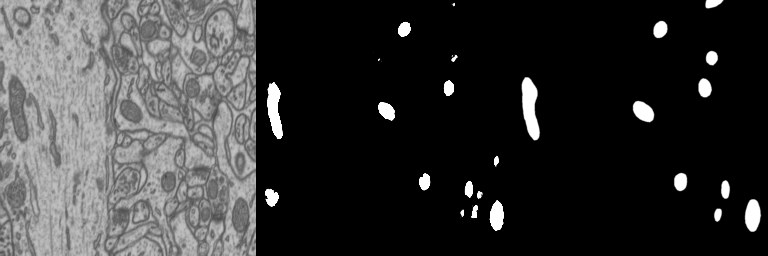

In [18]:
a